In [4]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from scipy.cluster.vq import whiten, kmeans2

In [5]:
def call_api(uri, result_key):
    json = {}
    try:
        json = requests.get(uri, headers = { 'X-Auth-Token': 'c52b7825851b4357af3e06c1888152f0' }).json()
        return json[result_key]
    except:
        print(json)
        return None

In [61]:
teams = call_api('http://api.football-data.org/v1/soccerseasons/439/teams', 'teams')
teams.extend(call_api('http://api.football-data.org/v1/soccerseasons/440/teams', 'teams'))
teams

[{'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/496/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/496/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/496'}},
  'code': None,
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/6/63/Rio_Ave_FC.svg',
  'name': 'FC Rio Ave',
  'shortName': 'Rio Ave',
  'squadMarketValue': None},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/503/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/503/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/503'}},
  'code': 'FCP',
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/e/ed/FC_Porto_1922-2005.svg',
  'name': 'FC Porto',
  'shortName': 'Porto',
  'squadMarketValue': None},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/583/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/583/players'},
   'self': {'href

In [94]:
def is_looser(team, fixture):
    scored_goals = 0
    missed_goals = 0
    
    def goals_count(time_part):
        result = {}
        if team['name'] == fixture['homeTeamName']:
            result['scored'] = time_part['goalsHomeTeam'] if time_part['goalsHomeTeam'] else 0
            result['missed'] = time_part['goalsAwayTeam'] if time_part['goalsAwayTeam'] else 0
        else:
            result['scored'] = time_part['goalsAwayTeam'] if time_part['goalsAwayTeam'] else 0
            result['missed'] = time_part['goalsHomeTeam'] if time_part['goalsHomeTeam'] else 0
        return result
    
    time_parts = [f['result'], ]
    if 'extraTime' in f['result']:
        time_parts.append(f['result']['extraTime'])
    if 'penaltyShootout' in f['result']:
        time_parts.append(f['result']['penaltyShootout'])
                          
    for time in time_parts:
        goals = goals_count(time)
        scored_goals += goals['scored']
        missed_goals += goals['missed']
   
    if scored_goals >= missed_goals:
        return False
    else: return True
    
    
for team in teams:
    looses = 0
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    if not fixtures:
        continue
    for f in fixtures:
        looses += is_looser(team, f)
    print('Team "{}", {} matches, {} looses'.format(team['name'], len(fixtures), looses))
    team['looses'] = looses
    team['fixtures'] = fixtures

Team "FC Rio Ave", 34 matches, 13 looses
Team "FC Porto", 44 matches, 5 looses
Team "Moreirense FC", 34 matches, 17 looses
Team "FC Paços de Ferreira", 34 matches, 14 looses
Team "Sporting CP", 40 matches, 11 looses
Team "Maritimo Funchal", 34 matches, 10 looses
Team "CD Tondela", 34 matches, 18 looses
Team "SL Benfica", 42 matches, 5 looses
Team "Boavista Porto FC", 34 matches, 11 looses
Team "FC Arouca", 34 matches, 20 looses
Team "Vitoria Setubal", 34 matches, 16 looses
Team "C.F. Os Belenenses", 34 matches, 16 looses
Team "Vitoria Guimaraes", 34 matches, 8 looses
Team "Sporting Braga", 34 matches, 10 looses
Team "GD Estoril Praia", 34 matches, 16 looses
Team "Feirense", 34 matches, 14 looses
Team "Nacional Funchal", 34 matches, 21 looses
Team "G.D. Chaves", 34 matches, 12 looses
Team "FC Basel", 6 matches, 4 looses
Team "Ludogorez Rasgrad", 7 matches, 3 looses
Team "FC Bayern München", 34 matches, 0 looses
Team "FC Rostov", 10 matches, 3 looses
Team "PSV Eindhoven", 34 matches, 0 l

In [93]:
team_for_pd = []
for team in teams:
    if team['fixtures']:
        team_for_pd.append({'name': team['name'], 
                            'fixtures': len(team['fixtures']), 
                            'looses': team['looses']
                           })
team_for_pd

[{'fixtures': 34, 'looses': 13, 'name': 'FC Rio Ave'},
 {'fixtures': 44, 'looses': 5, 'name': 'FC Porto'},
 {'fixtures': 34, 'looses': 17, 'name': 'Moreirense FC'},
 {'fixtures': 34, 'looses': 14, 'name': 'FC Paços de Ferreira'},
 {'fixtures': 40, 'looses': 11, 'name': 'Sporting CP'},
 {'fixtures': 34, 'looses': 10, 'name': 'Maritimo Funchal'},
 {'fixtures': 34, 'looses': 18, 'name': 'CD Tondela'},
 {'fixtures': 42, 'looses': 5, 'name': 'SL Benfica'},
 {'fixtures': 34, 'looses': 11, 'name': 'Boavista Porto FC'},
 {'fixtures': 34, 'looses': 20, 'name': 'FC Arouca'},
 {'fixtures': 34, 'looses': 16, 'name': 'Vitoria Setubal'},
 {'fixtures': 34, 'looses': 16, 'name': 'C.F. Os Belenenses'},
 {'fixtures': 34, 'looses': 8, 'name': 'Vitoria Guimaraes'},
 {'fixtures': 34, 'looses': 10, 'name': 'Sporting Braga'},
 {'fixtures': 34, 'looses': 16, 'name': 'GD Estoril Praia'},
 {'fixtures': 34, 'looses': 14, 'name': 'Feirense'},
 {'fixtures': 34, 'looses': 21, 'name': 'Nacional Funchal'},
 {'fixture

In [101]:
teams_pd = pd.DataFrame(team_for_pd)
teams_pd

,fixtures,looses,name
0,34,13,FC Rio Ave
1,44,5,FC Porto
2,34,17,Moreirense FC
3,34,14,FC Paços de Ferreira
4,40,11,Sporting CP
5,34,10,Maritimo Funchal
6,34,18,CD Tondela
7,42,5,SL Benfica
8,34,11,Boavista Porto FC
9,34,20,FC Arouca


In [102]:
del teams_pd['name']
whitened = whiten(teams_pd.as_matrix())
whitened

array([[ 2.45239786,  2.13856289],
       [ 3.17369134,  0.82252419],
       [ 2.45239786,  2.79658225],
       [ 2.45239786,  2.30306773],
       [ 2.88517395,  1.80955322],
       [ 2.45239786,  1.64504838],
       [ 2.45239786,  2.96108708],
       [ 3.02943265,  0.82252419],
       [ 2.45239786,  1.80955322],
       [ 2.45239786,  3.29009676],
       [ 2.45239786,  2.63207741],
       [ 2.45239786,  2.63207741],
       [ 2.45239786,  1.3160387 ],
       [ 2.45239786,  1.64504838],
       [ 2.45239786,  2.63207741],
       [ 2.45239786,  2.30306773],
       [ 2.45239786,  3.4546016 ],
       [ 2.45239786,  1.97405806],
       [ 0.43277609,  0.65801935],
       [ 0.50490544,  0.49351451],
       [ 2.45239786,  0.        ],
       [ 0.72129349,  0.49351451],
       [ 2.45239786,  0.        ],
       [ 3.60646743,  1.3160387 ],
       [ 3.46220874,  1.15153387],
       [ 0.57703479,  0.49351451],
       [ 0.43277609,  0.49351451],
       [ 3.31795004,  1.15153387],
       [ 3.02943265,

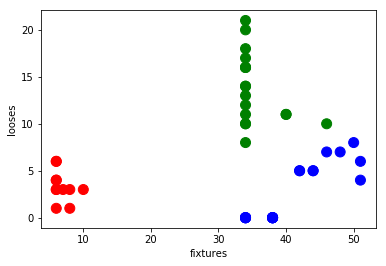

In [84]:
centroids, cluster_map = kmeans2(whitened, 3)
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
teams_pd.plot.scatter(x='fixtures', y='looses', c=colors, s=100)

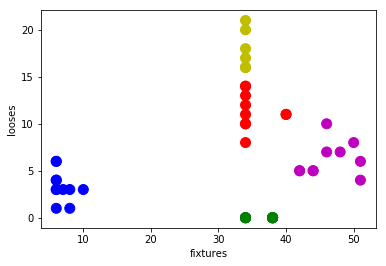

In [87]:
centroids, cluster_map = kmeans2(whitened, 5)
colors = [colors_map[c] for c in cluster_map]
teams_pd.plot.scatter(x='fixtures', y='looses', c=colors, s=100)